This notebook for fine-tuning the PaliGemma model wit the RISCM dataset and testing some model performance improvement suggestions.

Install the required packages with the following commands. If you are running this notebook on Colab, the second installation isn't neccessary. Otherwise, choose proper cuda version before installation.

In [1]:
!pip install tensorflow overrides ml_collections sentencepiece einops~=0.7 jax ipython pillow scikit-image matplotlib flax kagglehub polars keras-nightly wandb rouge_score
# !pip install -U "jax[cuda12]"

We load the data from drive. For other options, this code block isn't neccessary.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download the Google's "big_vision_repo" to use PaliGemma utilities.

In [3]:
import os
import sys

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
    !git clone --quiet --branch=main --depth=1 https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
    sys.path.append("big_vision_repo")

Import the required packages and check the availability of jax.

In [4]:
import base64
import functools
import html
import io
import warnings
import json

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections
import polars as pl

import tensorflow as tf
from tensorflow.keras import mixed_precision
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

import kagglehub

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt

# Import model definition from big_vision
from big_vision_repo.big_vision.models.proj.paligemma import paligemma
from big_vision_repo.big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
from big_vision_repo.big_vision.datasets.jsonl import DataSource
from big_vision_repo.big_vision.utils import tree_map_with_names, reshard, create_learning_rate_schedule, \
    tree_flatten_with_names
from big_vision_repo.big_vision.sharding import infer_sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

mixed_precision.set_global_policy("mixed_float16")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.5.2
JAX platform: cpu
JAX devices:  1


If you are using Colab, add your Kaggle credentials to secrets. Otherwise, please define your credentials with the code below.

In [5]:
# os.environ["KAGGLE_USERNAME"] = "KAGGLE_USERNAME"
# os.environ["KAGGLE_KEY"] = "KAGGLE_KEY"

Download the pre-trained model to be fine-tuned. We will use PaliGemma-2 3B model.

In [6]:
# Use these for PaliGemma-2 3B 224px²
LLM_VARIANT = "gemma2_2b"
MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"

"""
# Use these for PaliGemma 1:
LLM_VARIANT = "gemma_2b"
MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"
"""

if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "model/paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

Model path: /kaggle/input/paligemma-2/jax/paligemma2-3b-pt-224/1/./paligemma2-3b-pt-224.b16.npz


Define the model with the pre-trained weights and default config.

In [7]:
# Define model

# IMPORTANT: Gemma-2 has a "final_logits_softcap" property. Set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

Load all model parameters and add sharding to train the model on multiple GPUs, if available.

In [8]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
    if name.startswith("llm/layers/attn/"):  return True
    if name.startswith("llm/"):              return False
    if name.startswith("img/"):              return False
    raise ValueError(f"Unexpected param name {name}")


trainable_mask = tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")


@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
    # Cast others to float16, since some GPUs don't support bf16.
    return jax.tree.map(lambda p, m: p.astype(jnp.float32)
    if m else p.astype(jnp.float16),
                        params, trainable)


# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead, do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
    params[idx] = reshard(params[idx], sharding)
    params[idx] = maybe_cast_to_f32(params[idx], trainable)
    params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)


# Print params to show what the model is made of.
def parameter_overview(params):
    for path, arr in tree_flatten_with_names(params)[0]:
        print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")


print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

Load and transform the data for using the PaliGemma's DataSource object. While doing this, drop duplicate or partially unavailable samples.

In [9]:
from google.colab import userdata

data_path = userdata.get('DATA_PATH')  # Add data path as a Colab secret or give the direct path of the data
images_folder = "resized/"
captions_path = data_path + "captions.csv"

df_input = pl.read_csv(captions_path, separator=",", glob=False)
splits = df_input.select('split').unique()['split'].to_list()
for split in splits:
    filename = f"{data_path}{split}_captions.jsonl"
    if True:  # not os.path.isfile(filename):  # TODO: enable this check
        print(f"{split}_captions not found, starting to process...")
        df_split = df_input.filter(pl.col('split') == split)
        with open(filename, 'w') as f:
            for row in df_split.iter_rows(named=True):
                if os.path.isfile(f"{data_path}{images_folder}{row['image']}"):  # Skip the annotation if referenced image does not exist
                    for i in range(1, 6):
                        json_object = {
                            "prefix": "",
                            "image": f"{images_folder}{row['image']}",
                            "suffix": row[f"caption_{i}"],  # TODO: remove duplicate samples
                        }
                        f.write(json.dumps(json_object) + '\n')
    else:
        print(f"{split}_captions is already processed, skipping...")

train_captions not found, starting to process...
test_captions not found, starting to process...
val_captions not found, starting to process...


Define preprocess and postprocess methods.

In [10]:
def preprocess_image(image, size=224):
    # Model has been trained to handle images of different aspects ratios
    # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
    # options are helpful to improve quality in some tasks.

    image = np.asarray(image)
    if image.ndim == 2:  # Convert image without last channel into greyscale.
        image = np.stack((image,) * 3, axis=-1)
    image = image[..., :3]  # Remove alpha layer.
    assert image.shape[-1] == 3

    image = tf.constant(image)
    image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
    return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
    # Model has been trained to handle tokenized text composed of a prefix with
    # full attention and a suffix with causal attention.
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)  # 0 to use full attention for prefix.
    mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix
        mask_ar += [1] * len(suffix)  # 1 to use causal attention for suffix.
        mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

    mask_input = [1] * len(tokens)  # 1 if it's a token, 0 if padding.
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))


def postprocess_tokens(tokens):
    tokens = tokens.tolist()  # np.array to list[int]
    try:  # Remove tokens at and after EOS if any.
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)

Define the datasets and the data loaders.

In [11]:
SEQLEN = 128

train_dataset = DataSource(
    os.path.join(data_path, "train_captions.jsonl"),
    fopen_keys={"image": data_path}
)

val_dataset = DataSource(
    os.path.join(data_path, "val_captions.jsonl"),
    fopen_keys={"image": data_path})


def train_data_iterator():
    """Never ending iterator over training examples."""
    # Shuffle examples and repeat so one can train for many epochs.
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
    for example in dataset.as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        # TODO: #
        # numSegments = 4 * 4  # 14 * 14
        # segments = slic(image, n_segments=numSegments, sigma=5)
        # image = mark_boundaries(image, segments)
        #########

        prefix = "caption en"  # Could also be a different prefix per example.
        suffix = example["suffix"].decode().lower()
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "annotation": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
        }


def validation_data_iterator():
    """Single iterator over validation examples."""
    for example in val_dataset.get_tfdata().as_numpy_iterator():  # TODO: for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        # TODO: #
        # numSegments = 4 * 4  # 14 * 14
        # segments = slic(image, n_segments=numSegments, sigma=5)
        # image = mark_boundaries(image, segments)
        #########

        prefix = "caption en"  # Could also be a different prefix per example.
        tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

        suffix = example["suffix"].decode().lower()
        tmp_tokens, _, _, _ = preprocess_tokens(prefix, suffix, SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "annotation": np.asarray(tmp_tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_input": np.asarray(mask_input),
        }

Display some examples from the training dataset.

Training examples



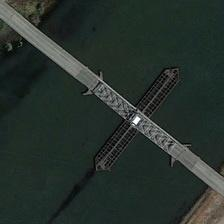
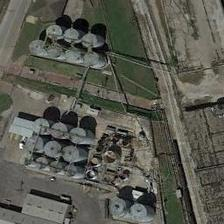
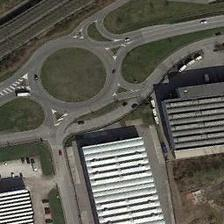

Validation examples



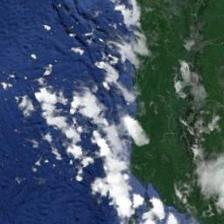
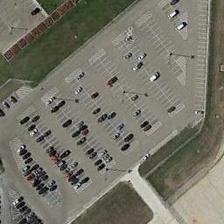
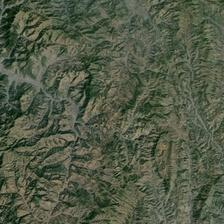

In [12]:
def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image, caption, annotation=None):
    image = ((image + 1) / 2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    annotation_div = ""
    if annotation:
        annotation_div = f"""
            <br/>
            <p style="width:256px; margin:10px; font-size:small;">{html.escape(annotation)}</p>
        """
    return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64, 64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
        {annotation_div}
    </div>
    """

html_out = ""
for idx, example in zip(range(3), train_data_iterator()):
    caption = postprocess_tokens(example["annotation"])  # detokenize model input.
    caption = caption[len("caption en\n"):]  # strip prefix
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

html_out = ""
for idx, example in zip(range(3), validation_data_iterator()):
    caption = postprocess_tokens(example["annotation"])  # detokenize model input.
    caption = caption[len("caption en\n"):]  # strip prefix
    html_out += render_example(example["image"], caption)

print("Validation examples")
display(HTML(html_out))

Define loss and inference functions.

In [13]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
    imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

    def loss_fn(params):
        text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
        logp = jax.nn.log_softmax(text_logits, axis=-1)

        # The model takes as input txts[:, :-1] but the loss is defined as predicting
        # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
        # are part of the loss (e.g. prefix and padded tokens are not included).
        mask_loss = batch["mask_loss"][:, 1:]
        targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

        # Compute the loss per example. i.e. the mean of per token pplx.
        # Since each example has a different number of tokens, normalize it.
        token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
        example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
        example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

        # batch_loss: mean of per example loss.
        return jnp.mean(example_loss)

    loss, grads = jax.value_and_grad(loss_fn)(params)

    # Apply gradients to trainable params using SGD.
    def apply_grad(param, gradient, trainable):
        if not trainable: return param
        return param - learning_rate * gradient

    params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

    return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, params, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
    outputs = []
    while True:
        # Construct a list of examples in the batch.
        examples = []
        try:
            for _ in range(batch_size):
                examples.append(next(data_iterator))
                examples[-1]["_mask"] = np.array(True)  # Indicates true example.
        except StopIteration:
            if len(examples) == 0:
                return outputs

        # Not enough examples to complete a batch. Pad by repeating last example.
        while len(examples) % batch_size:
            examples.append(dict(examples[-1]))
            examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = reshard(batch, data_sharding)

        # Make model predictions
        tokens = decode({"params": params}, batch=batch,
                        max_decode_len=seqlen, sampler=sampler)

        # Fetch model predictions to device and detokenize.
        tokens, mask = jax.device_get((tokens, batch["_mask"]))
        tokens = tokens[mask]  # remove padding examples.
        responses = [postprocess_tokens(t) for t in tokens]

        # Append to html output.
        for example, response in zip(examples, responses):
            caption = postprocess_tokens(example["annotation"])  # detokenize model input.
            caption = caption[len("caption en\n"):]  # strip prefix
            outputs.append((example["image"], response, caption))
            if num_examples and len(outputs) >= num_examples:
                return outputs

Initialize the W&B project and define the hyperparameters to be tested.

In [14]:
import wandb

wandb.login(key=userdata.get('WANDB_KEY'))

PROJECT_NAME = "DI725_project_2389088"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: erennarin-92 (erennarin-92-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Start the training with W&B sweeps.

In [15]:
from rouge_score import rouge_scorer

eval_methods = ['rouge1', 'rougeL', 'rougeLsum']

def train(batch_size, epochs, learning_rate):
    wandb.init(project=PROJECT_NAME)

    BATCH_SIZE = batch_size
    TRAIN_EXAMPLES = epochs
    LEARNING_RATE = learning_rate
    wandb.log({"batch_size": batch_size})
    wandb.log({"epochs": epochs})

    TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
    EVAL_STEPS = TRAIN_STEPS // 256
    EVAL_EXAMPLES = 4

    train_data_it = train_data_iterator()

    train_params = params.copy()

    sched_fn = create_learning_rate_schedule(
        total_steps=TRAIN_STEPS + 1, base=LEARNING_RATE,
        decay_type="cosine", warmup_percent=0.10)

    for step in range(1, TRAIN_STEPS + 1):
        # Make list of N training examples.
        examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = reshard(batch, data_sharding)

        # Training step and report training loss
        learning_rate = sched_fn(step)
        train_params, loss = update_fn(train_params, batch, learning_rate)

        loss = jax.device_get(loss)
        print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")
        wandb.log({"step": step, "learning_rate": learning_rate})
        wandb.log({"step": step, "train_loss": loss})

        if (step % EVAL_STEPS) == 0:
            print(f"Model predictions at step {step}")
            html_out = ""
            sum_score = 0
            for image, caption, annotation in make_predictions(
                    validation_data_iterator(), params=train_params, num_examples=EVAL_EXAMPLES, batch_size=BATCH_SIZE):  # TODO: make multiple predictions and get the average score
                # Evaluation
                scorer = rouge_scorer.RougeScorer(eval_methods, use_stemmer=True)
                scores = scorer.score(caption, annotation)
                sum_score += scores['rouge1'].fmeasure
                #print(f"Caption: {caption}")
                #print(f"Annotation: {annotation}")
                for method in eval_methods:
                    wandb.log({"step": step, f"{method}_score": scores[method].fmeasure})
                    wandb.log({"step": step, f"{method}_recall": scores[method].recall})
                    wandb.log({"step": step, f"{method}_precision": scores[method].precision})
                    print(f"{method}_score at step {step}: {scores[method].fmeasure}")
                html_out += render_example(image, caption, annotation)
            wandb.log({"step": step, "avg_rouge1_score": sum_score / EVAL_EXAMPLES})
            print(f"Average rouge1 score at step {step}: {sum_score / EVAL_EXAMPLES}")
            display(HTML(html_out))

{'batch_size': 4, 'epochs': 4096, 'learning_rate': 0.01}


step:  1/1024   lr: 0.00010   loss: 3.7324
step:  2/1024   lr: 0.00020   loss: 3.4377
step:  3/1024   lr: 0.00029   loss: 3.6276
step:  4/1024   lr: 0.00039   loss: 3.0308
Model predictions at step 4
rouge1_score at step 4: 0.4444444444444445
rougeL_score at step 4: 0.4444444444444445
rougeLsum_score at step 4: 0.4444444444444445
rouge1_score at step 4: 0.0
rougeL_score at step 4: 0.0
rougeLsum_score at step 4: 0.0
rouge1_score at step 4: 0.09999999999999999
rougeL_score at step 4: 0.09999999999999999
rougeLsum_score at step 4: 0.09999999999999999
rouge1_score at step 4: 0.30769230769230765
rougeL_score at step 4: 0.30769230769230765
rougeLsum_score at step 4: 0.30769230769230765
Average rouge1 score at step 4: 0.21303418803418805



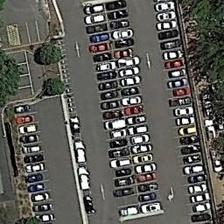
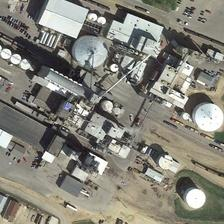
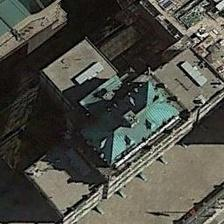
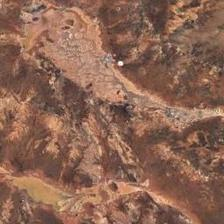

step:  5/1024   lr: 0.00049   loss: 3.9674
step:  6/1024   lr: 0.00059   loss: 2.9194
step:  7/1024   lr: 0.00069   loss: 2.8400
step:  8/1024   lr: 0.00078   loss: 3.1232
Model predictions at step 8
rouge1_score at step 8: 0.0
rougeL_score at step 8: 0.0
rougeLsum_score at step 8: 0.0
rouge1_score at step 8: 0.25
rougeL_score at step 8: 0.125
rougeLsum_score at step 8: 0.125
rouge1_score at step 8: 0.3529411764705882
rougeL_score at step 8: 0.3529411764705882
rougeLsum_score at step 8: 0.3529411764705882
rouge1_score at step 8: 0.4
rougeL_score at step 8: 0.2
rougeLsum_score at step 8: 0.2
Average rouge1 score at step 8: 0.25073529411764706



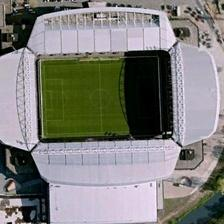
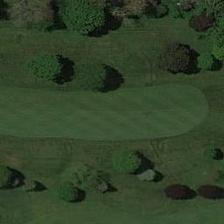
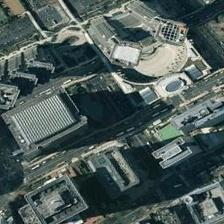
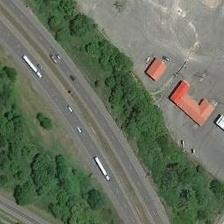

step:  9/1024   lr: 0.00088   loss: 2.3746
step: 10/1024   lr: 0.00098   loss: 3.1251
step: 11/1024   lr: 0.00108   loss: 3.3627
step: 12/1024   lr: 0.00118   loss: 2.1421
Model predictions at step 12
rouge1_score at step 12: 0.42857142857142855
rougeL_score at step 12: 0.42857142857142855
rougeLsum_score at step 12: 0.42857142857142855
rouge1_score at step 12: 0.15384615384615385
rougeL_score at step 12: 0.15384615384615385
rougeLsum_score at step 12: 0.15384615384615385
rouge1_score at step 12: 0.26666666666666666
rougeL_score at step 12: 0.26666666666666666
rougeLsum_score at step 12: 0.26666666666666666
rouge1_score at step 12: 0.380952380952381
rougeL_score at step 12: 0.380952380952381
rougeLsum_score at step 12: 0.380952380952381
Average rouge1 score at step 12: 0.30750915750915747



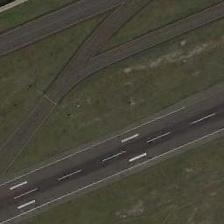
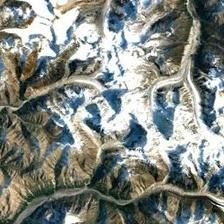
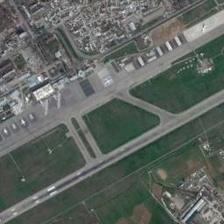
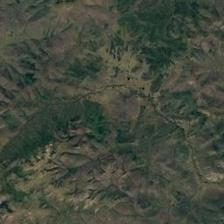

step: 13/1024   lr: 0.00127   loss: 3.1415
step: 14/1024   lr: 0.00137   loss: 2.0045
step: 15/1024   lr: 0.00147   loss: 2.5136
step: 16/1024   lr: 0.00157   loss: 2.8082
Model predictions at step 16
rouge1_score at step 16: 0.09523809523809522
rougeL_score at step 16: 0.09523809523809522
rougeLsum_score at step 16: 0.09523809523809522
rouge1_score at step 16: 0.3157894736842105
rougeL_score at step 16: 0.10526315789473685
rougeLsum_score at step 16: 0.10526315789473685
rouge1_score at step 16: 0.4347826086956522
rougeL_score at step 16: 0.34782608695652173
rougeLsum_score at step 16: 0.34782608695652173
rouge1_score at step 16: 0.5555555555555556
rougeL_score at step 16: 0.5555555555555556
rougeLsum_score at step 16: 0.5555555555555556
Average rouge1 score at step 16: 0.3503414332933784



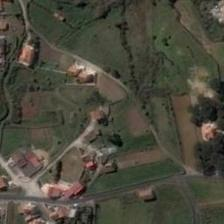
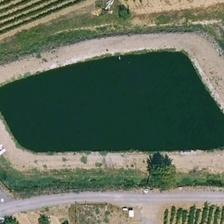
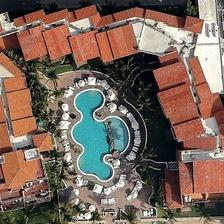
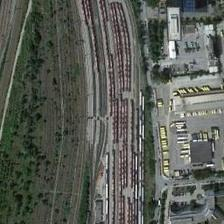

step: 17/1024   lr: 0.00167   loss: 2.7000
step: 18/1024   lr: 0.00176   loss: 2.6333
step: 19/1024   lr: 0.00186   loss: 2.4677
step: 20/1024   lr: 0.00196   loss: 2.1868
Model predictions at step 20
rouge1_score at step 20: 0.37499999999999994
rougeL_score at step 20: 0.37499999999999994
rougeLsum_score at step 20: 0.37499999999999994
rouge1_score at step 20: 0.47058823529411764
rougeL_score at step 20: 0.47058823529411764
rougeLsum_score at step 20: 0.47058823529411764
rouge1_score at step 20: 0.26666666666666666
rougeL_score at step 20: 0.26666666666666666
rougeLsum_score at step 20: 0.26666666666666666
rouge1_score at step 20: 0.16666666666666666
rougeL_score at step 20: 0.16666666666666666
rougeLsum_score at step 20: 0.16666666666666666
Average rouge1 score at step 20: 0.3197303921568627



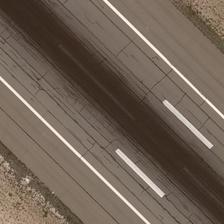
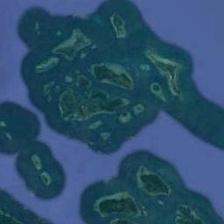
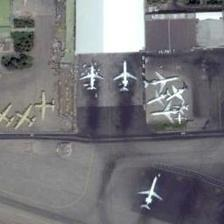
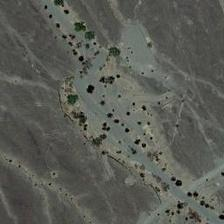

step: 21/1024   lr: 0.00206   loss: 1.7362
step: 22/1024   lr: 0.00216   loss: 2.3223
step: 23/1024   lr: 0.00225   loss: 2.1641
step: 24/1024   lr: 0.00235   loss: 2.4526
Model predictions at step 24
rouge1_score at step 24: 0.36363636363636365
rougeL_score at step 24: 0.2727272727272727
rougeLsum_score at step 24: 0.2727272727272727
rouge1_score at step 24: 0.1904761904761905
rougeL_score at step 24: 0.09523809523809525
rougeLsum_score at step 24: 0.09523809523809525
rouge1_score at step 24: 0.16
rougeL_score at step 24: 0.16
rougeLsum_score at step 24: 0.16
rouge1_score at step 24: 0.2727272727272727
rougeL_score at step 24: 0.18181818181818182
rougeLsum_score at step 24: 0.18181818181818182
Average rouge1 score at step 24: 0.2467099567099567



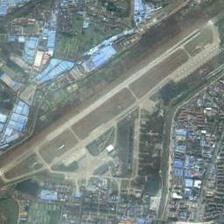
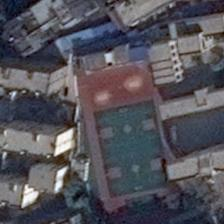
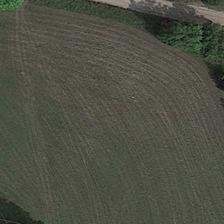
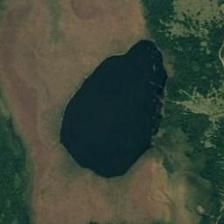

step: 25/1024   lr: 0.00245   loss: 2.5906
step: 26/1024   lr: 0.00255   loss: 1.2552
step: 27/1024   lr: 0.00265   loss: 2.0618
step: 28/1024   lr: 0.00275   loss: 1.9590
Model predictions at step 28
rouge1_score at step 28: 0.3
rougeL_score at step 28: 0.09999999999999999
rougeLsum_score at step 28: 0.09999999999999999
rouge1_score at step 28: 0.43478260869565216
rougeL_score at step 28: 0.2608695652173913
rougeLsum_score at step 28: 0.2608695652173913
rouge1_score at step 28: 0.1739130434782609
rougeL_score at step 28: 0.1739130434782609
rougeLsum_score at step 28: 0.1739130434782609
rouge1_score at step 28: 0.5333333333333333
rougeL_score at step 28: 0.5333333333333333
rougeLsum_score at step 28: 0.5333333333333333
Average rouge1 score at step 28: 0.3605072463768116



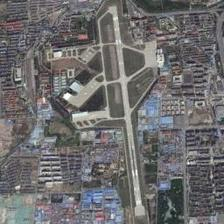
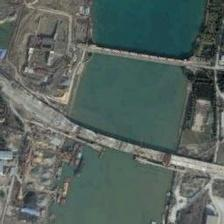
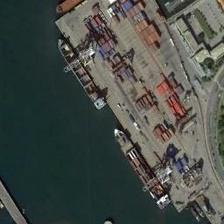
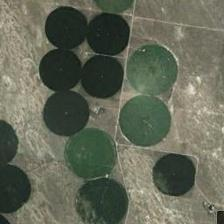

step: 29/1024   lr: 0.00284   loss: 2.7502
step: 30/1024   lr: 0.00294   loss: 1.4993
step: 31/1024   lr: 0.00304   loss: 1.4475
step: 32/1024   lr: 0.00314   loss: 2.2122
Model predictions at step 32
rouge1_score at step 32: 0.3
rougeL_score at step 32: 0.3
rougeLsum_score at step 32: 0.3
rouge1_score at step 32: 0.4615384615384615
rougeL_score at step 32: 0.4615384615384615
rougeLsum_score at step 32: 0.4615384615384615
rouge1_score at step 32: 0.375
rougeL_score at step 32: 0.375
rougeLsum_score at step 32: 0.375
rouge1_score at step 32: 0.13333333333333333
rougeL_score at step 32: 0.13333333333333333
rougeLsum_score at step 32: 0.13333333333333333
Average rouge1 score at step 32: 0.3174679487179487



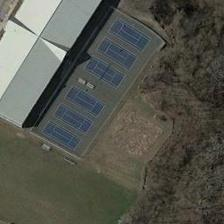
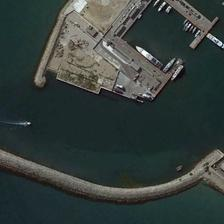
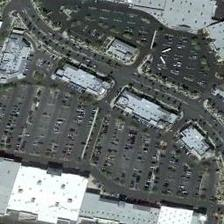
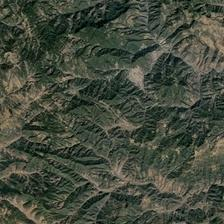

step: 33/1024   lr: 0.00324   loss: 1.8949
step: 34/1024   lr: 0.00333   loss: 2.4227
step: 35/1024   lr: 0.00343   loss: 2.7642
step: 36/1024   lr: 0.00353   loss: 2.0842
Model predictions at step 36
rouge1_score at step 36: 0.39999999999999997
rougeL_score at step 36: 0.39999999999999997
rougeLsum_score at step 36: 0.39999999999999997
rouge1_score at step 36: 0.5
rougeL_score at step 36: 0.5
rougeLsum_score at step 36: 0.5
rouge1_score at step 36: 0.23076923076923075
rougeL_score at step 36: 0.23076923076923075
rougeLsum_score at step 36: 0.23076923076923075
rouge1_score at step 36: 0.631578947368421
rougeL_score at step 36: 0.631578947368421
rougeLsum_score at step 36: 0.631578947368421
Average rouge1 score at step 36: 0.44058704453441294



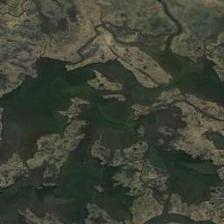
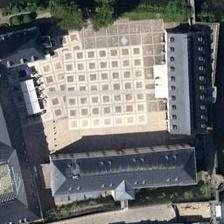
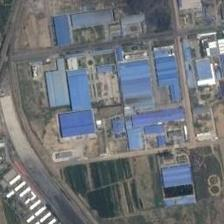
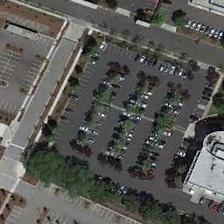

step: 37/1024   lr: 0.00363   loss: 2.3829
step: 38/1024   lr: 0.00373   loss: 1.5172
step: 39/1024   lr: 0.00382   loss: 1.6634
step: 40/1024   lr: 0.00392   loss: 2.5081
Model predictions at step 40
rouge1_score at step 40: 0.5714285714285715
rougeL_score at step 40: 0.5714285714285715
rougeLsum_score at step 40: 0.5714285714285715
rouge1_score at step 40: 0.2222222222222222
rougeL_score at step 40: 0.2222222222222222
rougeLsum_score at step 40: 0.2222222222222222
rouge1_score at step 40: 0.2962962962962963
rougeL_score at step 40: 0.2222222222222222
rougeLsum_score at step 40: 0.2222222222222222
rouge1_score at step 40: 0.16
rougeL_score at step 40: 0.08
rougeLsum_score at step 40: 0.08
Average rouge1 score at step 40: 0.3124867724867725



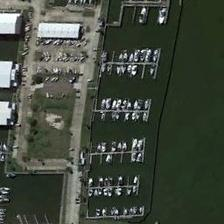
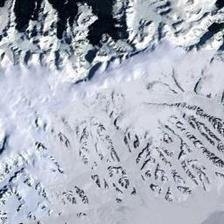
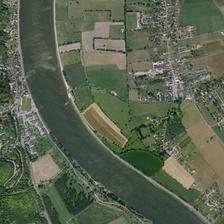
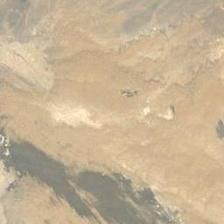

step: 41/1024   lr: 0.00402   loss: 1.6413
step: 42/1024   lr: 0.00412   loss: 1.6425
step: 43/1024   lr: 0.00422   loss: 1.1037
step: 44/1024   lr: 0.00431   loss: 2.0141
Model predictions at step 44
rouge1_score at step 44: 0.2222222222222222
rougeL_score at step 44: 0.2222222222222222
rougeLsum_score at step 44: 0.2222222222222222
rouge1_score at step 44: 0.30769230769230765
rougeL_score at step 44: 0.30769230769230765
rougeLsum_score at step 44: 0.30769230769230765
rouge1_score at step 44: 0.33333333333333326
rougeL_score at step 44: 0.11111111111111112
rougeLsum_score at step 44: 0.11111111111111112
rouge1_score at step 44: 0.0
rougeL_score at step 44: 0.0
rougeLsum_score at step 44: 0.0
Average rouge1 score at step 44: 0.21581196581196577



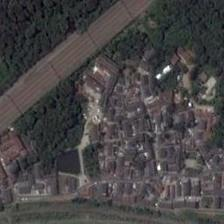
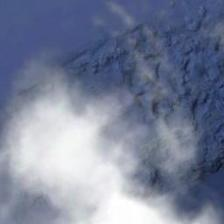
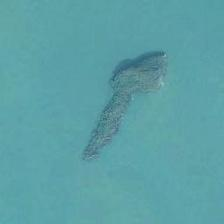
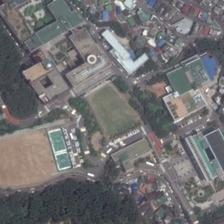

step: 45/1024   lr: 0.00441   loss: 2.4674
step: 46/1024   lr: 0.00451   loss: 1.9767
step: 47/1024   lr: 0.00461   loss: 2.7782
step: 48/1024   lr: 0.00471   loss: 1.9680
Model predictions at step 48
rouge1_score at step 48: 0.375
rougeL_score at step 48: 0.375
rougeLsum_score at step 48: 0.375
rouge1_score at step 48: 0.3157894736842105
rougeL_score at step 48: 0.2105263157894737
rougeLsum_score at step 48: 0.2105263157894737
rouge1_score at step 48: 0.3
rougeL_score at step 48: 0.3
rougeLsum_score at step 48: 0.3
rouge1_score at step 48: 0.2
rougeL_score at step 48: 0.2
rougeLsum_score at step 48: 0.2
Average rouge1 score at step 48: 0.2976973684210526



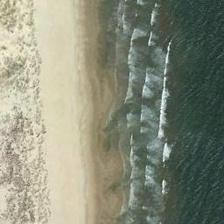
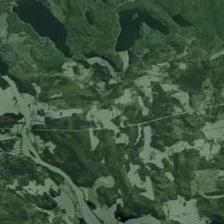
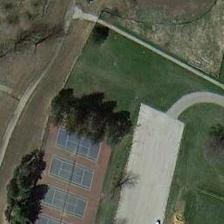
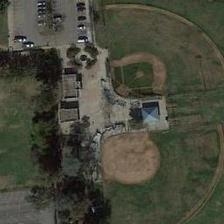

step: 49/1024   lr: 0.00480   loss: 1.9750
step: 50/1024   lr: 0.00490   loss: 2.7173
step: 51/1024   lr: 0.00500   loss: 2.3351
step: 52/1024   lr: 0.00510   loss: 2.2835
Model predictions at step 52
rouge1_score at step 52: 0.3333333333333333
rougeL_score at step 52: 0.25
rougeLsum_score at step 52: 0.25
rouge1_score at step 52: 0.23529411764705882
rougeL_score at step 52: 0.23529411764705882
rougeLsum_score at step 52: 0.23529411764705882
rouge1_score at step 52: 0.17391304347826086
rougeL_score at step 52: 0.17391304347826086
rougeLsum_score at step 52: 0.17391304347826086
rouge1_score at step 52: 0.36363636363636365
rougeL_score at step 52: 0.18181818181818182
rougeLsum_score at step 52: 0.18181818181818182
Average rouge1 score at step 52: 0.27654421452375416



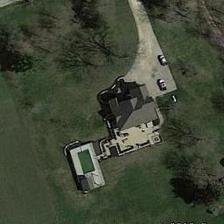
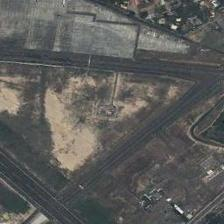
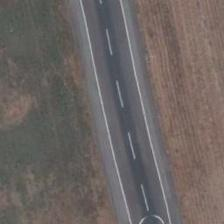
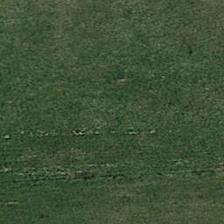

step: 53/1024   lr: 0.00520   loss: 2.4977
step: 54/1024   lr: 0.00529   loss: 2.6355
step: 55/1024   lr: 0.00539   loss: 1.9734
step: 56/1024   lr: 0.00549   loss: 1.7584
Model predictions at step 56
rouge1_score at step 56: 0.11111111111111112
rougeL_score at step 56: 0.11111111111111112
rougeLsum_score at step 56: 0.11111111111111112
rouge1_score at step 56: 0.3448275862068966
rougeL_score at step 56: 0.27586206896551724
rougeLsum_score at step 56: 0.27586206896551724
rouge1_score at step 56: 0.3157894736842105
rougeL_score at step 56: 0.3157894736842105
rougeLsum_score at step 56: 0.3157894736842105
rouge1_score at step 56: 0.6153846153846153
rougeL_score at step 56: 0.4615384615384615
rougeLsum_score at step 56: 0.4615384615384615
Average rouge1 score at step 56: 0.3467781965967084



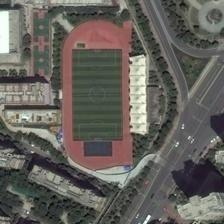
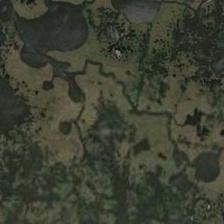
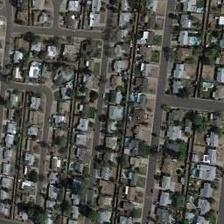
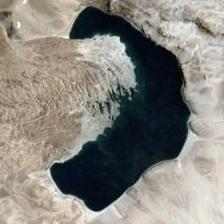

step: 57/1024   lr: 0.00559   loss: 1.9225
step: 58/1024   lr: 0.00569   loss: 2.0709
step: 59/1024   lr: 0.00578   loss: 1.3276
step: 60/1024   lr: 0.00588   loss: 2.4845
Model predictions at step 60
rouge1_score at step 60: 0.09523809523809525
rougeL_score at step 60: 0.09523809523809525
rougeLsum_score at step 60: 0.09523809523809525
rouge1_score at step 60: 0.4166666666666667
rougeL_score at step 60: 0.3333333333333333
rougeLsum_score at step 60: 0.3333333333333333
rouge1_score at step 60: 0.32432432432432434
rougeL_score at step 60: 0.16216216216216217
rougeLsum_score at step 60: 0.16216216216216217
rouge1_score at step 60: 0.13333333333333333
rougeL_score at step 60: 0.13333333333333333
rougeLsum_score at step 60: 0.13333333333333333
Average rouge1 score at step 60: 0.2423906048906049



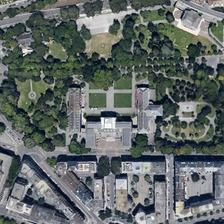
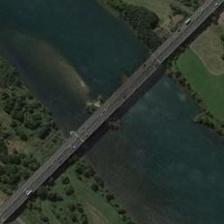
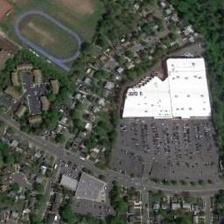
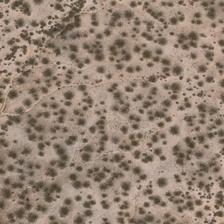

step: 61/1024   lr: 0.00598   loss: 2.5228
step: 62/1024   lr: 0.00608   loss: 2.2791
step: 63/1024   lr: 0.00618   loss: 1.9064
step: 64/1024   lr: 0.00627   loss: 2.5952
Model predictions at step 64
rouge1_score at step 64: 0.4
rougeL_score at step 64: 0.2
rougeLsum_score at step 64: 0.2
rouge1_score at step 64: 0.33333333333333326
rougeL_score at step 64: 0.33333333333333326
rougeLsum_score at step 64: 0.33333333333333326
rouge1_score at step 64: 0.28571428571428575
rougeL_score at step 64: 0.1904761904761905
rougeLsum_score at step 64: 0.1904761904761905
rouge1_score at step 64: 0.875
rougeL_score at step 64: 0.875
rougeLsum_score at step 64: 0.875
Average rouge1 score at step 64: 0.47351190476190474



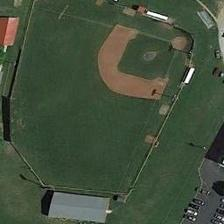
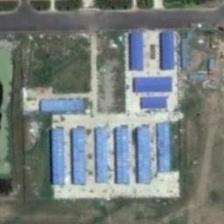
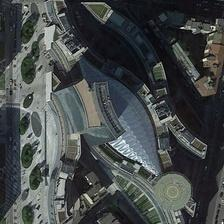
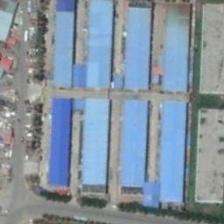

step: 65/1024   lr: 0.00637   loss: 2.5109
step: 66/1024   lr: 0.00647   loss: 2.3770
step: 67/1024   lr: 0.00657   loss: 1.6650
step: 68/1024   lr: 0.00667   loss: 1.7396
Model predictions at step 68
rouge1_score at step 68: 0.26666666666666666
rougeL_score at step 68: 0.13333333333333333
rougeLsum_score at step 68: 0.13333333333333333
rouge1_score at step 68: 0.08695652173913043
rougeL_score at step 68: 0.08695652173913043
rougeLsum_score at step 68: 0.08695652173913043
rouge1_score at step 68: 0.375
rougeL_score at step 68: 0.25
rougeLsum_score at step 68: 0.25
rouge1_score at step 68: 0.10526315789473685
rougeL_score at step 68: 0.10526315789473685
rougeLsum_score at step 68: 0.10526315789473685
Average rouge1 score at step 68: 0.20847158657513348



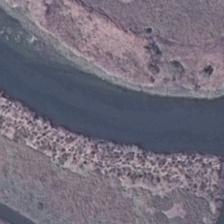
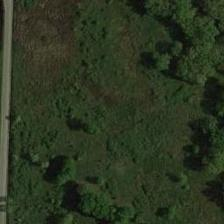
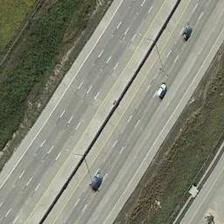
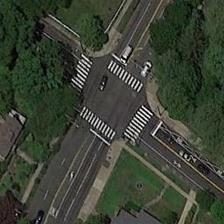

step: 69/1024   lr: 0.00676   loss: 1.4494
step: 70/1024   lr: 0.00686   loss: 1.6654
step: 71/1024   lr: 0.00696   loss: 1.5250
step: 72/1024   lr: 0.00706   loss: 1.8584
Model predictions at step 72
rouge1_score at step 72: 0.3
rougeL_score at step 72: 0.3
rougeLsum_score at step 72: 0.3
rouge1_score at step 72: 0.4000000000000001
rougeL_score at step 72: 0.20000000000000004
rougeLsum_score at step 72: 0.20000000000000004
rouge1_score at step 72: 0.11111111111111112
rougeL_score at step 72: 0.11111111111111112
rougeLsum_score at step 72: 0.11111111111111112
rouge1_score at step 72: 0.19047619047619047
rougeL_score at step 72: 0.19047619047619047
rougeLsum_score at step 72: 0.19047619047619047
Average rouge1 score at step 72: 0.2503968253968254



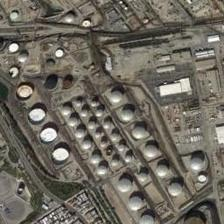
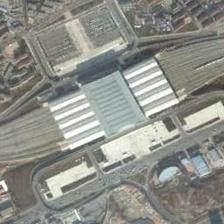
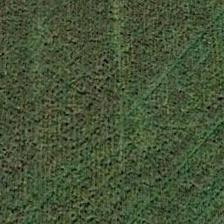
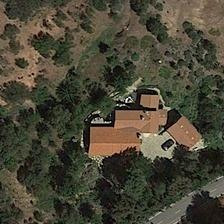

step: 73/1024   lr: 0.00716   loss: 2.4005
step: 74/1024   lr: 0.00725   loss: 1.9206
step: 75/1024   lr: 0.00735   loss: 2.3823
step: 76/1024   lr: 0.00745   loss: 1.9329
Model predictions at step 76
rouge1_score at step 76: 0.42857142857142855
rougeL_score at step 76: 0.42857142857142855
rougeLsum_score at step 76: 0.42857142857142855
rouge1_score at step 76: 0.13333333333333333
rougeL_score at step 76: 0.13333333333333333
rougeLsum_score at step 76: 0.13333333333333333
rouge1_score at step 76: 0.26666666666666666
rougeL_score at step 76: 0.26666666666666666
rougeLsum_score at step 76: 0.26666666666666666
rouge1_score at step 76: 0.35714285714285715
rougeL_score at step 76: 0.35714285714285715
rougeLsum_score at step 76: 0.35714285714285715
Average rouge1 score at step 76: 0.29642857142857143



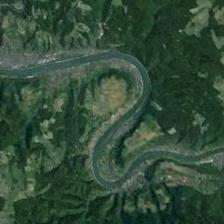
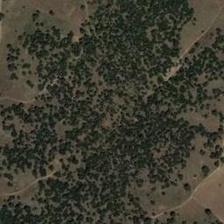
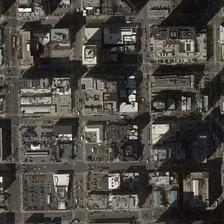
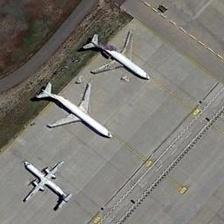

step: 77/1024   lr: 0.00755   loss: 2.2746
step: 78/1024   lr: 0.00765   loss: 1.8715
step: 79/1024   lr: 0.00775   loss: 2.6651
step: 80/1024   lr: 0.00784   loss: 1.9631
Model predictions at step 80
rouge1_score at step 80: 0.0
rougeL_score at step 80: 0.0
rougeLsum_score at step 80: 0.0
rouge1_score at step 80: 0.23999999999999996
rougeL_score at step 80: 0.23999999999999996
rougeLsum_score at step 80: 0.23999999999999996
rouge1_score at step 80: 0.4444444444444444
rougeL_score at step 80: 0.4444444444444444
rougeLsum_score at step 80: 0.4444444444444444
rouge1_score at step 80: 0.0
rougeL_score at step 80: 0.0
rougeLsum_score at step 80: 0.0
Average rouge1 score at step 80: 0.1711111111111111



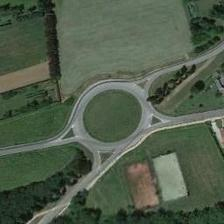
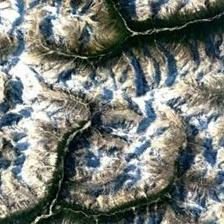
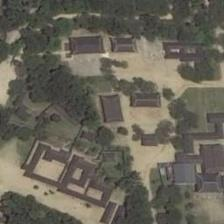
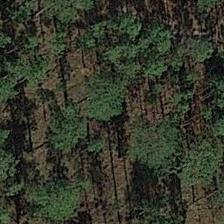

step: 81/1024   lr: 0.00794   loss: 2.4835
step: 82/1024   lr: 0.00804   loss: 1.7432
step: 83/1024   lr: 0.00814   loss: 1.6070
step: 84/1024   lr: 0.00824   loss: 1.8284
Model predictions at step 84
rouge1_score at step 84: 0.27272727272727276
rougeL_score at step 84: 0.18181818181818182
rougeLsum_score at step 84: 0.18181818181818182
rouge1_score at step 84: 0.10526315789473685
rougeL_score at step 84: 0.10526315789473685
rougeLsum_score at step 84: 0.10526315789473685
rouge1_score at step 84: 0.34782608695652173
rougeL_score at step 84: 0.17391304347826086
rougeLsum_score at step 84: 0.17391304347826086
rouge1_score at step 84: 0.5925925925925926
rougeL_score at step 84: 0.3703703703703703
rougeLsum_score at step 84: 0.3703703703703703
Average rouge1 score at step 84: 0.329602277542781



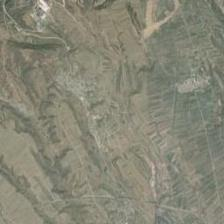
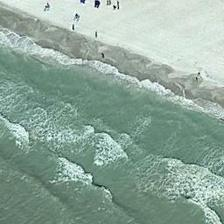
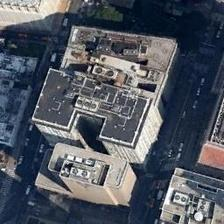
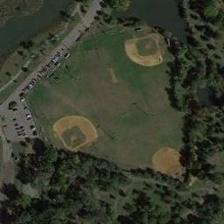

step: 85/1024   lr: 0.00833   loss: 2.7198
step: 86/1024   lr: 0.00843   loss: 1.6463
step: 87/1024   lr: 0.00853   loss: 1.7347
step: 88/1024   lr: 0.00863   loss: 2.5263
Model predictions at step 88
rouge1_score at step 88: 0.23529411764705882
rougeL_score at step 88: 0.11764705882352941
rougeLsum_score at step 88: 0.11764705882352941
rouge1_score at step 88: 0.3333333333333333
rougeL_score at step 88: 0.3333333333333333
rougeLsum_score at step 88: 0.3333333333333333
rouge1_score at step 88: 0.2222222222222222
rougeL_score at step 88: 0.1111111111111111
rougeLsum_score at step 88: 0.1111111111111111
rouge1_score at step 88: 0.1904761904761905
rougeL_score at step 88: 0.1904761904761905
rougeLsum_score at step 88: 0.1904761904761905
Average rouge1 score at step 88: 0.2453314659197012



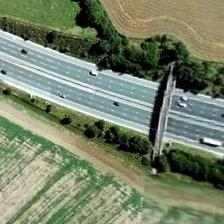
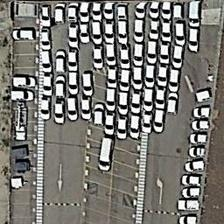
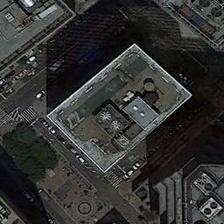
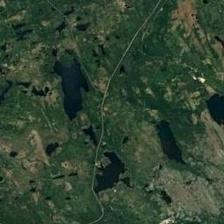

step: 89/1024   lr: 0.00873   loss: 2.0858
step: 90/1024   lr: 0.00882   loss: 2.0098
step: 91/1024   lr: 0.00892   loss: 2.0314
step: 92/1024   lr: 0.00902   loss: 2.0623
Model predictions at step 92
rouge1_score at step 92: 0.32
rougeL_score at step 92: 0.32
rougeLsum_score at step 92: 0.32
rouge1_score at step 92: 0.25
rougeL_score at step 92: 0.125
rougeLsum_score at step 92: 0.125
rouge1_score at step 92: 0.09523809523809525
rougeL_score at step 92: 0.09523809523809525
rougeLsum_score at step 92: 0.09523809523809525
rouge1_score at step 92: 0.5333333333333333
rougeL_score at step 92: 0.39999999999999997
rougeLsum_score at step 92: 0.39999999999999997
Average rouge1 score at step 92: 0.29964285714285716



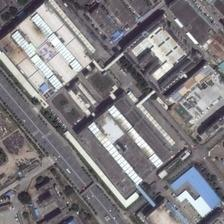
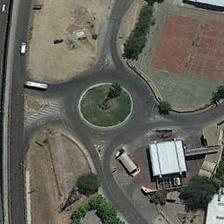
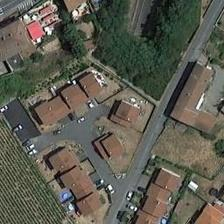
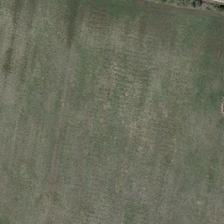

step: 93/1024   lr: 0.00912   loss: 1.8875
step: 94/1024   lr: 0.00922   loss: 1.7694
step: 95/1024   lr: 0.00931   loss: 1.6862
step: 96/1024   lr: 0.00941   loss: 2.6166
Model predictions at step 96
rouge1_score at step 96: 0.34782608695652173
rougeL_score at step 96: 0.2608695652173913
rougeLsum_score at step 96: 0.2608695652173913
rouge1_score at step 96: 0.0
rougeL_score at step 96: 0.0
rougeLsum_score at step 96: 0.0
rouge1_score at step 96: 0.14285714285714288
rougeL_score at step 96: 0.14285714285714288
rougeLsum_score at step 96: 0.14285714285714288
rouge1_score at step 96: 0.2
rougeL_score at step 96: 0.2
rougeLsum_score at step 96: 0.2
Average rouge1 score at step 96: 0.17267080745341618



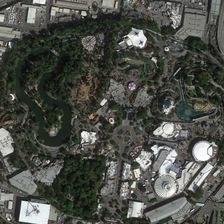
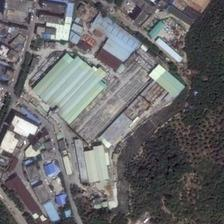
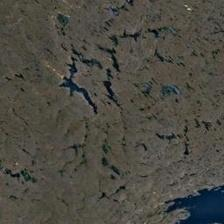
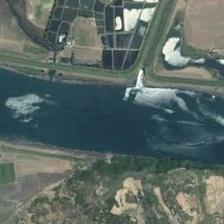

step: 97/1024   lr: 0.00951   loss: 1.9684
step: 98/1024   lr: 0.00961   loss: 2.3397
step: 99/1024   lr: 0.00971   loss: 1.5840
step: 100/1024   lr: 0.00980   loss: 1.7930
Model predictions at step 100
rouge1_score at step 100: 0.10526315789473685
rougeL_score at step 100: 0.10526315789473685
rougeLsum_score at step 100: 0.10526315789473685
rouge1_score at step 100: 0.25
rougeL_score at step 100: 0.125
rougeLsum_score at step 100: 0.125
rouge1_score at step 100: 0.7142857142857143
rougeL_score at step 100: 0.5714285714285714
rougeLsum_score at step 100: 0.5714285714285714
rouge1_score at step 100: 0.39999999999999997
rougeL_score at step 100: 0.26666666666666666
rougeLsum_score at step 100: 0.26666666666666666
Average rouge1 score at step 100: 0.36738721804511276



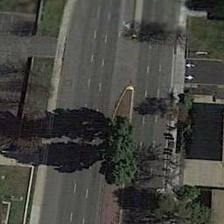
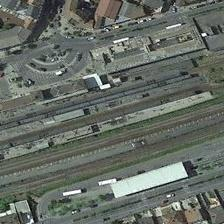
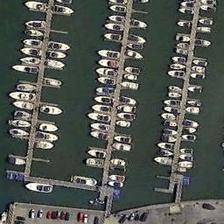
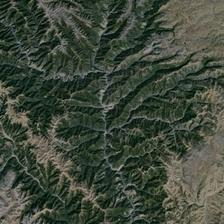

step: 101/1024   lr: 0.00990   loss: 2.0076
step: 102/1024   lr: 0.01000   loss: 2.2084
step: 103/1024   lr: 0.01000   loss: 2.7582
step: 104/1024   lr: 0.01000   loss: 1.9957
Model predictions at step 104
rouge1_score at step 104: 0.3333333333333333
rougeL_score at step 104: 0.3333333333333333
rougeLsum_score at step 104: 0.3333333333333333
rouge1_score at step 104: 0.25
rougeL_score at step 104: 0.25
rougeLsum_score at step 104: 0.25
rouge1_score at step 104: 0.0
rougeL_score at step 104: 0.0
rougeLsum_score at step 104: 0.0
rouge1_score at step 104: 0.10526315789473684
rougeL_score at step 104: 0.10526315789473684
rougeLsum_score at step 104: 0.10526315789473684
Average rouge1 score at step 104: 0.17214912280701752



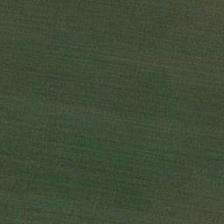
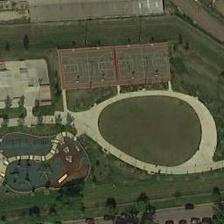
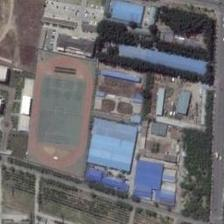
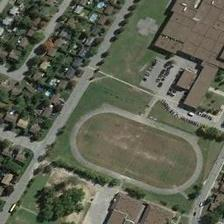

step: 105/1024   lr: 0.01000   loss: 2.0562
step: 106/1024   lr: 0.01000   loss: 1.6162
step: 107/1024   lr: 0.01000   loss: 2.2900
step: 108/1024   lr: 0.01000   loss: 1.8015
Model predictions at step 108
rouge1_score at step 108: 0.26666666666666666
rougeL_score at step 108: 0.26666666666666666
rougeLsum_score at step 108: 0.26666666666666666
rouge1_score at step 108: 0.09090909090909091
rougeL_score at step 108: 0.09090909090909091
rougeLsum_score at step 108: 0.09090909090909091
rouge1_score at step 108: 0.25
rougeL_score at step 108: 0.25
rougeLsum_score at step 108: 0.25
rouge1_score at step 108: 0.15999999999999998
rougeL_score at step 108: 0.15999999999999998
rougeLsum_score at step 108: 0.15999999999999998
Average rouge1 score at step 108: 0.1918939393939394



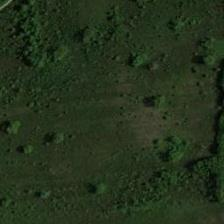
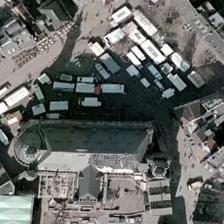
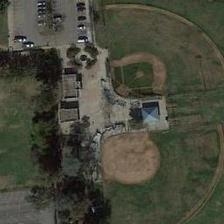
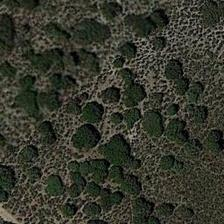

step: 109/1024   lr: 0.01000   loss: 1.9858
step: 110/1024   lr: 0.01000   loss: 1.9661
step: 111/1024   lr: 0.01000   loss: 1.5173
step: 112/1024   lr: 0.01000   loss: 1.9658
Model predictions at step 112
rouge1_score at step 112: 0.4
rougeL_score at step 112: 0.4
rougeLsum_score at step 112: 0.4
rouge1_score at step 112: 0.17391304347826086
rougeL_score at step 112: 0.17391304347826086
rougeLsum_score at step 112: 0.17391304347826086
rouge1_score at step 112: 0.23529411764705882
rougeL_score at step 112: 0.23529411764705882
rougeLsum_score at step 112: 0.23529411764705882
rouge1_score at step 112: 0.33333333333333337
rougeL_score at step 112: 0.33333333333333337
rougeLsum_score at step 112: 0.33333333333333337
Average rouge1 score at step 112: 0.28563512361466326



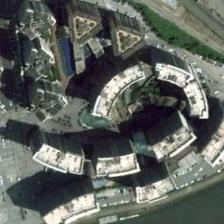
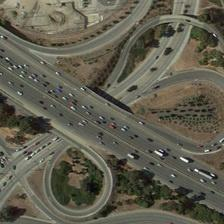
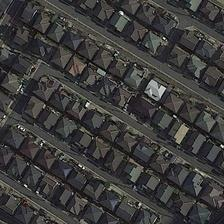
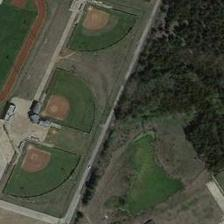

step: 113/1024   lr: 0.01000   loss: 1.5273
step: 114/1024   lr: 0.01000   loss: 1.9608
step: 115/1024   lr: 0.01000   loss: 2.0531
step: 116/1024   lr: 0.00999   loss: 1.9198
Model predictions at step 116
rouge1_score at step 116: 0.47058823529411764
rougeL_score at step 116: 0.23529411764705882
rougeLsum_score at step 116: 0.23529411764705882
rouge1_score at step 116: 0.608695652173913
rougeL_score at step 116: 0.608695652173913
rougeLsum_score at step 116: 0.608695652173913
rouge1_score at step 116: 0.4000000000000001
rougeL_score at step 116: 0.20000000000000004
rougeLsum_score at step 116: 0.20000000000000004
rouge1_score at step 116: 0.22222222222222224
rougeL_score at step 116: 0.22222222222222224
rougeLsum_score at step 116: 0.22222222222222224
Average rouge1 score at step 116: 0.42537652742256327



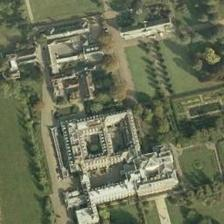
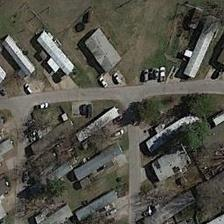
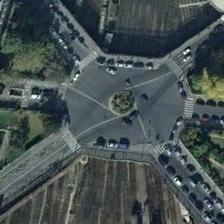
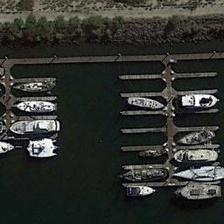

step: 117/1024   lr: 0.00999   loss: 1.3967
step: 118/1024   lr: 0.00999   loss: 1.8739
step: 119/1024   lr: 0.00999   loss: 1.4068
step: 120/1024   lr: 0.00999   loss: 2.1689
Model predictions at step 120
rouge1_score at step 120: 0.32
rougeL_score at step 120: 0.16
rougeLsum_score at step 120: 0.16
rouge1_score at step 120: 0.3
rougeL_score at step 120: 0.3
rougeLsum_score at step 120: 0.3
rouge1_score at step 120: 0.24999999999999994
rougeL_score at step 120: 0.24999999999999994
rougeLsum_score at step 120: 0.24999999999999994
rouge1_score at step 120: 0.22222222222222224
rougeL_score at step 120: 0.22222222222222224
rougeLsum_score at step 120: 0.22222222222222224
Average rouge1 score at step 120: 0.27305555555555555



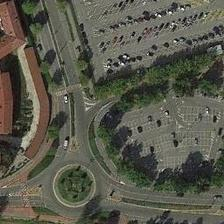
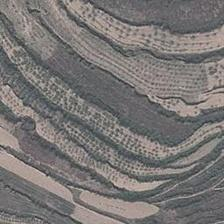
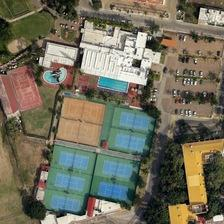
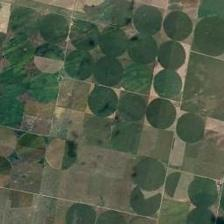

step: 121/1024   lr: 0.00999   loss: 1.8333
step: 122/1024   lr: 0.00999   loss: 2.0219
step: 123/1024   lr: 0.00999   loss: 1.4268
step: 124/1024   lr: 0.00999   loss: 2.0126
Model predictions at step 124
rouge1_score at step 124: 0.2
rougeL_score at step 124: 0.1
rougeLsum_score at step 124: 0.1
rouge1_score at step 124: 0.37499999999999994
rougeL_score at step 124: 0.37499999999999994
rougeLsum_score at step 124: 0.37499999999999994
rouge1_score at step 124: 0.26666666666666666
rougeL_score at step 124: 0.13333333333333333
rougeLsum_score at step 124: 0.13333333333333333
rouge1_score at step 124: 0.380952380952381
rougeL_score at step 124: 0.380952380952381
rougeLsum_score at step 124: 0.380952380952381
Average rouge1 score at step 124: 0.3056547619047619



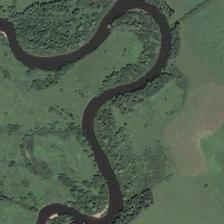
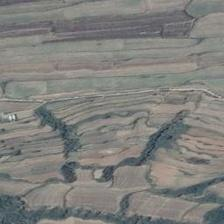
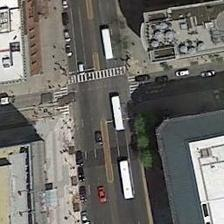
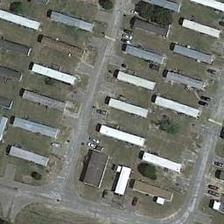

step: 125/1024   lr: 0.00998   loss: 1.9184
step: 126/1024   lr: 0.00998   loss: 1.4905
step: 127/1024   lr: 0.00998   loss: 1.7363
step: 128/1024   lr: 0.00998   loss: 1.7324
Model predictions at step 128
rouge1_score at step 128: 0.26666666666666666
rougeL_score at step 128: 0.26666666666666666
rougeLsum_score at step 128: 0.26666666666666666
rouge1_score at step 128: 0.39999999999999997
rougeL_score at step 128: 0.32
rougeLsum_score at step 128: 0.32
rouge1_score at step 128: 0.4705882352941177
rougeL_score at step 128: 0.3529411764705882
rougeLsum_score at step 128: 0.3529411764705882
rouge1_score at step 128: 0.33333333333333326
rougeL_score at step 128: 0.22222222222222224
rougeLsum_score at step 128: 0.22222222222222224
Average rouge1 score at step 128: 0.3676470588235294



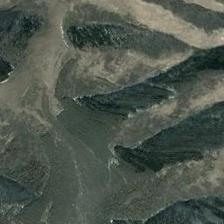
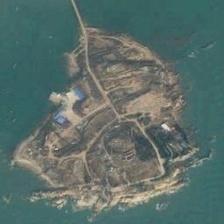
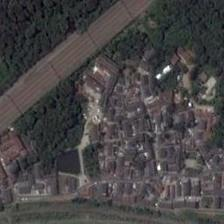
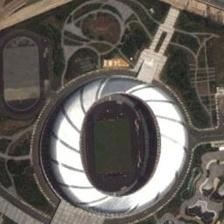

step: 129/1024   lr: 0.00998   loss: 1.9978
step: 130/1024   lr: 0.00998   loss: 2.4744
step: 131/1024   lr: 0.00998   loss: 2.0475
step: 132/1024   lr: 0.00997   loss: 2.2233
Model predictions at step 132
rouge1_score at step 132: 0.19047619047619047
rougeL_score at step 132: 0.19047619047619047
rougeLsum_score at step 132: 0.19047619047619047
rouge1_score at step 132: 0.8750000000000001
rougeL_score at step 132: 0.8750000000000001
rougeLsum_score at step 132: 0.8750000000000001
rouge1_score at step 132: 0.39999999999999997
rougeL_score at step 132: 0.3
rougeLsum_score at step 132: 0.3
rouge1_score at step 132: 0.3448275862068966
rougeL_score at step 132: 0.27586206896551724
rougeLsum_score at step 132: 0.27586206896551724
Average rouge1 score at step 132: 0.4525759441707718



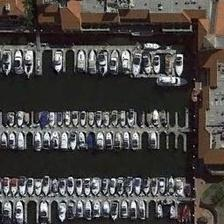
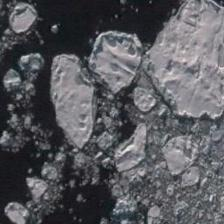
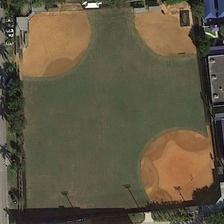
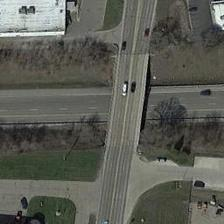

step: 133/1024   lr: 0.00997   loss: 2.3404
step: 134/1024   lr: 0.00997   loss: 1.7251
step: 135/1024   lr: 0.00997   loss: 1.6457
step: 136/1024   lr: 0.00997   loss: 2.0262
Model predictions at step 136
rouge1_score at step 136: 0.23999999999999996
rougeL_score at step 136: 0.23999999999999996
rougeLsum_score at step 136: 0.23999999999999996
rouge1_score at step 136: 0.08
rougeL_score at step 136: 0.08
rougeLsum_score at step 136: 0.08
rouge1_score at step 136: 0.8333333333333334
rougeL_score at step 136: 0.8333333333333334
rougeLsum_score at step 136: 0.8333333333333334
rouge1_score at step 136: 0.25
rougeL_score at step 136: 0.25
rougeLsum_score at step 136: 0.25
Average rouge1 score at step 136: 0.35083333333333333



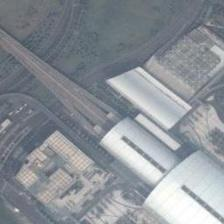
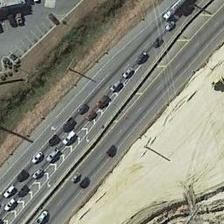
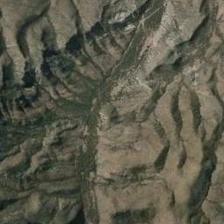
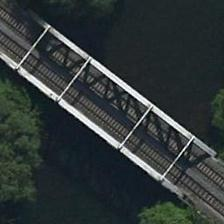

step: 137/1024   lr: 0.00996   loss: 1.8972
step: 138/1024   lr: 0.00996   loss: 1.7039
step: 139/1024   lr: 0.00996   loss: 1.6069
step: 140/1024   lr: 0.00996   loss: 1.8711
Model predictions at step 140
rouge1_score at step 140: 0.1818181818181818
rougeL_score at step 140: 0.0909090909090909
rougeLsum_score at step 140: 0.0909090909090909
rouge1_score at step 140: 0.24000000000000002
rougeL_score at step 140: 0.16
rougeLsum_score at step 140: 0.16
rouge1_score at step 140: 0.2857142857142857
rougeL_score at step 140: 0.17142857142857143
rougeLsum_score at step 140: 0.17142857142857143
rouge1_score at step 140: 0.375
rougeL_score at step 140: 0.375
rougeLsum_score at step 140: 0.375
Average rouge1 score at step 140: 0.27063311688311686



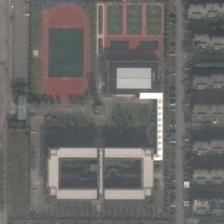
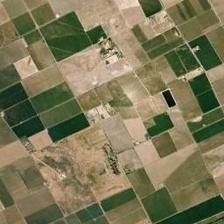
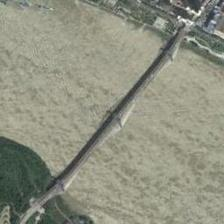
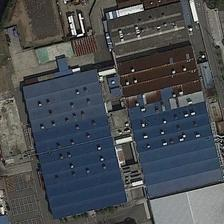

step: 141/1024   lr: 0.00996   loss: 2.0824
step: 142/1024   lr: 0.00995   loss: 1.8518
step: 143/1024   lr: 0.00995   loss: 1.8346
step: 144/1024   lr: 0.00995   loss: 1.8573
Model predictions at step 144
rouge1_score at step 144: 0.2857142857142857
rougeL_score at step 144: 0.2857142857142857
rougeLsum_score at step 144: 0.2857142857142857
rouge1_score at step 144: 0.13793103448275862
rougeL_score at step 144: 0.06896551724137931
rougeLsum_score at step 144: 0.06896551724137931
rouge1_score at step 144: 0.19999999999999998
rougeL_score at step 144: 0.19999999999999998
rougeLsum_score at step 144: 0.19999999999999998
rouge1_score at step 144: 0.380952380952381
rougeL_score at step 144: 0.380952380952381
rougeLsum_score at step 144: 0.380952380952381
Average rouge1 score at step 144: 0.25114942528735634



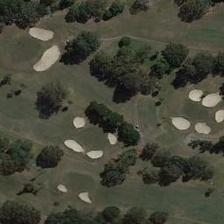
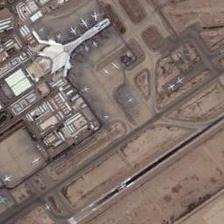
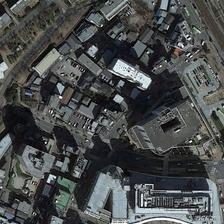
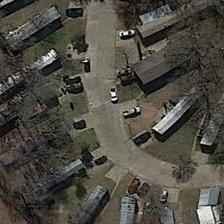

step: 145/1024   lr: 0.00995   loss: 2.5443
step: 146/1024   lr: 0.00994   loss: 2.1874
step: 147/1024   lr: 0.00994   loss: 1.5283
step: 148/1024   lr: 0.00994   loss: 1.9704
Model predictions at step 148
rouge1_score at step 148: 0.47058823529411764
rougeL_score at step 148: 0.35294117647058826
rougeLsum_score at step 148: 0.35294117647058826
rouge1_score at step 148: 0.07142857142857142
rougeL_score at step 148: 0.07142857142857142
rougeLsum_score at step 148: 0.07142857142857142
rouge1_score at step 148: 0.14814814814814817
rougeL_score at step 148: 0.14814814814814817
rougeLsum_score at step 148: 0.14814814814814817
rouge1_score at step 148: 0.39999999999999997
rougeL_score at step 148: 0.3
rougeLsum_score at step 148: 0.3
Average rouge1 score at step 148: 0.2725412387177093



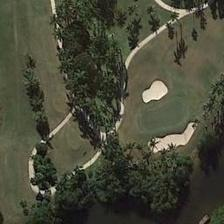
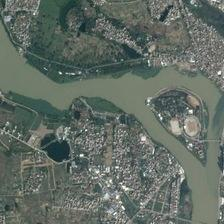
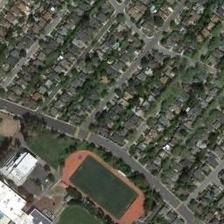
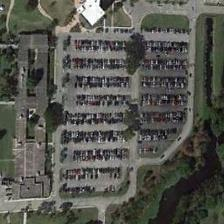

step: 149/1024   lr: 0.00994   loss: 2.2597
step: 150/1024   lr: 0.00993   loss: 1.2613
step: 151/1024   lr: 0.00993   loss: 2.7920
step: 152/1024   lr: 0.00993   loss: 1.9535
Model predictions at step 152
rouge1_score at step 152: 0.6666666666666665
rougeL_score at step 152: 0.6666666666666665
rougeLsum_score at step 152: 0.6666666666666665
rouge1_score at step 152: 0.15384615384615383
rougeL_score at step 152: 0.15384615384615383
rougeLsum_score at step 152: 0.15384615384615383
rouge1_score at step 152: 0.26666666666666666
rougeL_score at step 152: 0.26666666666666666
rougeLsum_score at step 152: 0.26666666666666666
rouge1_score at step 152: 0.3636363636363636
rougeL_score at step 152: 0.3636363636363636
rougeLsum_score at step 152: 0.3636363636363636
Average rouge1 score at step 152: 0.36270396270396266



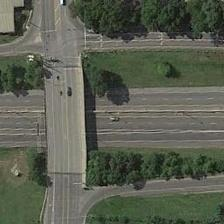
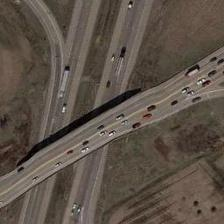
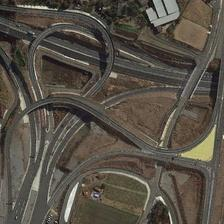
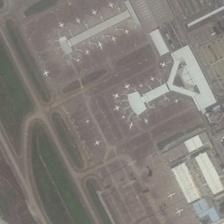

step: 153/1024   lr: 0.00992   loss: 1.5650
step: 154/1024   lr: 0.00992   loss: 1.9677
step: 155/1024   lr: 0.00992   loss: 1.5769
step: 156/1024   lr: 0.00992   loss: 1.8004
Model predictions at step 156
rouge1_score at step 156: 0.588235294117647
rougeL_score at step 156: 0.47058823529411764
rougeLsum_score at step 156: 0.47058823529411764
rouge1_score at step 156: 0.43478260869565216
rougeL_score at step 156: 0.26086956521739135
rougeLsum_score at step 156: 0.26086956521739135
rouge1_score at step 156: 0.33333333333333337
rougeL_score at step 156: 0.16666666666666669
rougeLsum_score at step 156: 0.16666666666666669
rouge1_score at step 156: 0.6363636363636364
rougeL_score at step 156: 0.36363636363636365
rougeLsum_score at step 156: 0.36363636363636365
Average rouge1 score at step 156: 0.4981787181275672



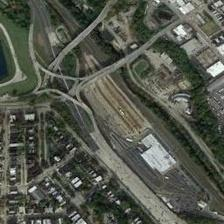
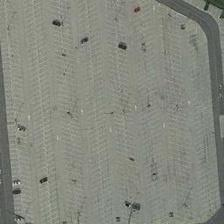
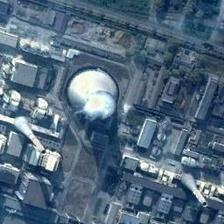
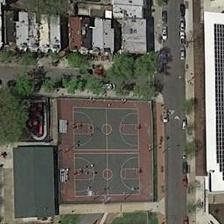

step: 157/1024   lr: 0.00991   loss: 1.2184
step: 158/1024   lr: 0.00991   loss: 1.6857
step: 159/1024   lr: 0.00991   loss: 1.7227
step: 160/1024   lr: 0.00990   loss: 2.5001
Model predictions at step 160
rouge1_score at step 160: 0.3333333333333333
rougeL_score at step 160: 0.3333333333333333
rougeLsum_score at step 160: 0.3333333333333333
rouge1_score at step 160: 0.4444444444444444
rougeL_score at step 160: 0.4444444444444444
rougeLsum_score at step 160: 0.4444444444444444
rouge1_score at step 160: 0.1111111111111111
rougeL_score at step 160: 0.1111111111111111
rougeLsum_score at step 160: 0.1111111111111111
rouge1_score at step 160: 0.14814814814814817
rougeL_score at step 160: 0.14814814814814817
rougeLsum_score at step 160: 0.14814814814814817
Average rouge1 score at step 160: 0.25925925925925924



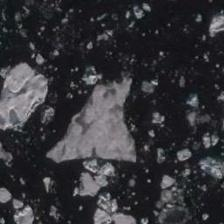
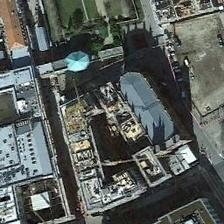
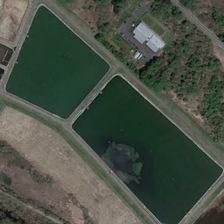
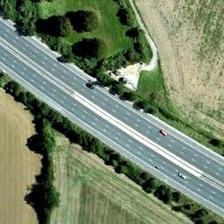

step: 161/1024   lr: 0.00990   loss: 1.7960
step: 162/1024   lr: 0.00990   loss: 1.3322
step: 163/1024   lr: 0.00989   loss: 2.4179
step: 164/1024   lr: 0.00989   loss: 1.7843
Model predictions at step 164
rouge1_score at step 164: 0.38095238095238093
rougeL_score at step 164: 0.2857142857142857
rougeLsum_score at step 164: 0.2857142857142857
rouge1_score at step 164: 0.26086956521739135
rougeL_score at step 164: 0.1739130434782609
rougeLsum_score at step 164: 0.1739130434782609
rouge1_score at step 164: 0.2
rougeL_score at step 164: 0.2
rougeLsum_score at step 164: 0.2
rouge1_score at step 164: 0.5714285714285714
rougeL_score at step 164: 0.5714285714285714
rougeLsum_score at step 164: 0.5714285714285714
Average rouge1 score at step 164: 0.3533126293995859



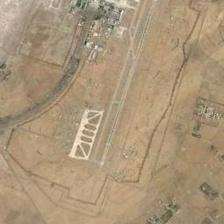
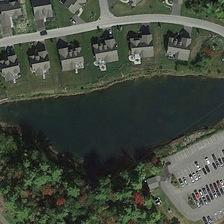
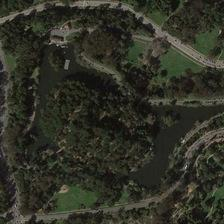
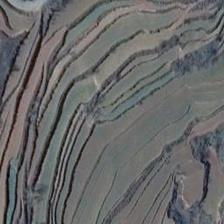

step: 165/1024   lr: 0.00989   loss: 1.6970
step: 166/1024   lr: 0.00988   loss: 1.4394
step: 167/1024   lr: 0.00988   loss: 2.3211
step: 168/1024   lr: 0.00987   loss: 1.8524
Model predictions at step 168
rouge1_score at step 168: 0.38095238095238093
rougeL_score at step 168: 0.38095238095238093
rougeLsum_score at step 168: 0.38095238095238093
rouge1_score at step 168: 0.2727272727272727
rougeL_score at step 168: 0.1818181818181818
rougeLsum_score at step 168: 0.1818181818181818
rouge1_score at step 168: 0.4166666666666667
rougeL_score at step 168: 0.25
rougeLsum_score at step 168: 0.25
rouge1_score at step 168: 0.2
rougeL_score at step 168: 0.2
rougeLsum_score at step 168: 0.2
Average rouge1 score at step 168: 0.3175865800865801



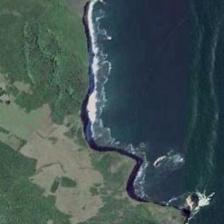
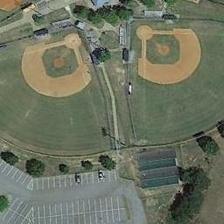
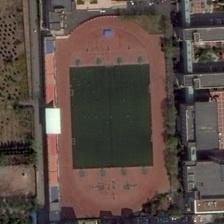
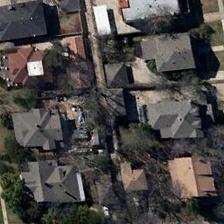

step: 169/1024   lr: 0.00987   loss: 1.9916
step: 170/1024   lr: 0.00987   loss: 1.4357
step: 171/1024   lr: 0.00986   loss: 1.5365
step: 172/1024   lr: 0.00986   loss: 2.0485
Model predictions at step 172
rouge1_score at step 172: 0.375
rougeL_score at step 172: 0.375
rougeLsum_score at step 172: 0.375
rouge1_score at step 172: 0.3157894736842105
rougeL_score at step 172: 0.3157894736842105
rougeLsum_score at step 172: 0.3157894736842105
rouge1_score at step 172: 0.4615384615384615
rougeL_score at step 172: 0.4615384615384615
rougeLsum_score at step 172: 0.4615384615384615
rouge1_score at step 172: 0.5161290322580645
rougeL_score at step 172: 0.5161290322580645
rougeLsum_score at step 172: 0.5161290322580645
Average rouge1 score at step 172: 0.41711424187018414



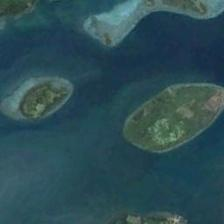
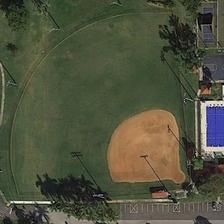
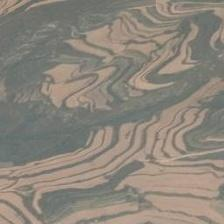
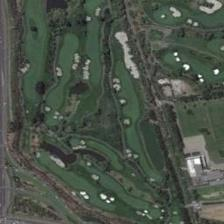

step: 173/1024   lr: 0.00985   loss: 1.4746
step: 174/1024   lr: 0.00985   loss: 1.9514
step: 175/1024   lr: 0.00985   loss: 1.4444
step: 176/1024   lr: 0.00984   loss: 2.1765
Model predictions at step 176
rouge1_score at step 176: 0.5714285714285715
rougeL_score at step 176: 0.5714285714285715
rougeLsum_score at step 176: 0.5714285714285715
rouge1_score at step 176: 0.34285714285714286
rougeL_score at step 176: 0.34285714285714286
rougeLsum_score at step 176: 0.34285714285714286
rouge1_score at step 176: 0.26666666666666666
rougeL_score at step 176: 0.13333333333333333
rougeLsum_score at step 176: 0.13333333333333333
rouge1_score at step 176: 0.25
rougeL_score at step 176: 0.25
rougeLsum_score at step 176: 0.25
Average rouge1 score at step 176: 0.35773809523809524



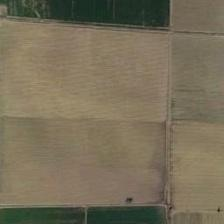
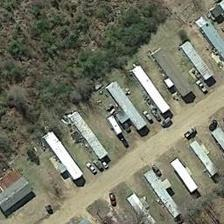
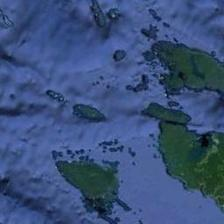
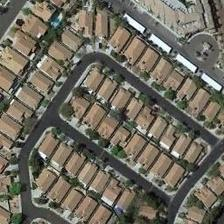

In [ ]:
import itertools

hyperparameters = {
    "batch_size": [4],        #[4,    4,    4,      4,      4',      1',      4]
    "epochs": [4096],         #[4096, 4096, 4096,   8192,   4096',   256',    4096]
    "learning_rate": [0.01],  #[0.03, 0.01, 0.001,  0.01,   0.01',   0.01',   0.01]
}

keys = list(hyperparameters.keys())
values = list(hyperparameters.values())

for value in itertools.product(*values):
    config = dict(zip(keys, value))
    print(config)
    train(**config)
    print("Training completed, checking for new configuration.")
print("Training completed.")